In [1]:
import glob
import os

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from xclim.indices.generic import select_resample_op
from scipy.stats import genextreme as gev
from pyextremes import EVA

In [2]:
ari_file = ''
ari_var = None
param_file = ''
data_files = ''
data_var = None
ari_plot = ''
shape_plot = ''
scale_plot = ''
location_plot = ''

#lat = -37.51
#lon = 145.31
#var = 'FFDI'
#ari = 20
#ari_file = '/g/data/wp00/users/dbi599/test_space/ffdi_test2.nc'
#param_file = '/g/data/wp00/users/dbi599/test_space/param_test.nc'
#data_files = '/g/data/wp00/QQSCALE/GFDL-ESM2M/FFDI/rcp45/2016-2045/ffdi.????.nc'
#ari_plot = '/g/data/wp00/users/dbi599/test_space/ffdi_ARI_20yr_GFDL-ESM2M-QME_rcp45_2016-2045.png'
#shape_plot = '/g/data/wp00/users/dbi599/test_space/ffdi_annual-daily-max_GEV-shape_GFDL-ESM2M-QME_rcp45_2016-2045.png'
#scale_plot = '/g/data/wp00/users/dbi599/test_space/ffdi_annual-daily-max_GEV-scale_GFDL-ESM2M-QME_rcp45_2016-2045.png'
#location_plot = '/g/data/wp00/users/dbi599/test_space/ffdi_annual-daily-max_GEV-location_GFDL-ESM2M-QME_rcp45_2016-2045.png'

In [3]:
# Parameters
lat = -34.0
lon = 138.6
ari_var = "FFDI"
ari = 20
ari_file = "/g/data/wp00/QQSCALE/GFDL-ESM2M/FFDI/rcp85/2036-2065/GEV/FFDI_GFDL-ESM2M_rcp85_2036-2065_ARI20_ANN.nc"
data_files = "/g/data/wp00/QQSCALE/GFDL-ESM2M/FFDI/rcp85/2036-2065/ffdi.????.nc*"
data_var = "FFDI"
param_file = "/g/data/wp00/users/dbi599/test_space/params_FFDI_GFDL-ESM2M_rcp85_2036-2065_ARI_ANN.nc"


In [4]:
assert 'lat' in locals(), "Must provide a latitude (-p lat)"
assert 'lon' in locals(), "Must provide a longitude (-p lon)"
assert 'ari' in locals(), "Must provide an ARI (-p ari)"

In [5]:
if data_files:
    data_files = glob.glob(data_files)
    data_files.sort()
    ds_data = xr.open_mfdataset(data_files)

## Australia-wide analysis

In [6]:
def plot_aus(
    da,
    title,
    outfile=None,
    cmap=None,
    levels=None,
    extend=None,
    clabel=None,
    point=[],
):
    """Plot Australia
    
    Args:
      da (xarray DataArray)
      selection (dict)
    
    """
    fig = plt.figure(figsize=[12,5])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    da.plot(
        ax=ax,
        levels=levels,
        extend=extend,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'label': clabel},
        cmap=cmap,
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    plt.title(title)
    if point:
        lon, lat = point
        ax.plot(lon, lat, 'o', color='cyan', markerfacecolor='none', zorder=5, transform=ccrs.PlateCarree())
    if outfile:
        plt.savefig(
            outfile,
            bbox_inches='tight',
            dpi=300,
            facecolor='white',
        )
    else:
        plt.show()
    plt.close()

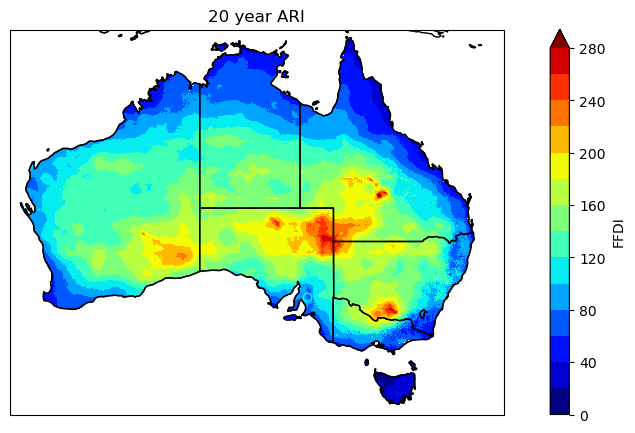

Point 20 year ARI: 75.25


In [7]:
if os.path.isfile(ari_file):
    ds_ari = xr.open_dataset(ari_file)
    da_ari = ds_ari[ari_var].sel({'return_period': ari})
    plot_aus(
        da_ari,
        f'{ari} year ARI',
        outfile=ari_plot,
        cmap='jet',
        levels=np.arange(0, 281, 20),
        extend='max',
        clabel='FFDI',
        point=[lon, lat],
    )
    point_ari = da_ari.sel({'lat': lat, 'lon': lon}, method='nearest', drop=True).values
    print(f'Point {ari} year ARI: {point_ari:.2f}')

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/dask/array/reductions.py:615: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


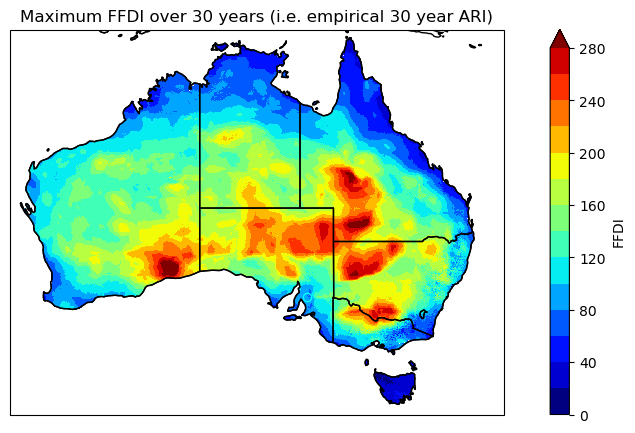

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/dask/array/reductions.py:615: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Point maximum: 78.57


In [8]:
if data_files:
    da_max = ds_data[data_var].max(dim='time', skipna=True)
    da_max = da_max.where(da_max > 2)
    plot_aus(
        da_max,
        f'Maximum FFDI over 30 years (i.e. empirical 30 year ARI)',
        cmap='jet',
        levels=np.arange(0, 281, 20),
        extend='max',
        clabel='FFDI',
        point=[lon, lat],
    )
    point_max = da_max.sel({'lat': lat, 'lon': lon}, method='nearest', drop=True).values
    print(f'Point maximum: {point_max:.2f}')

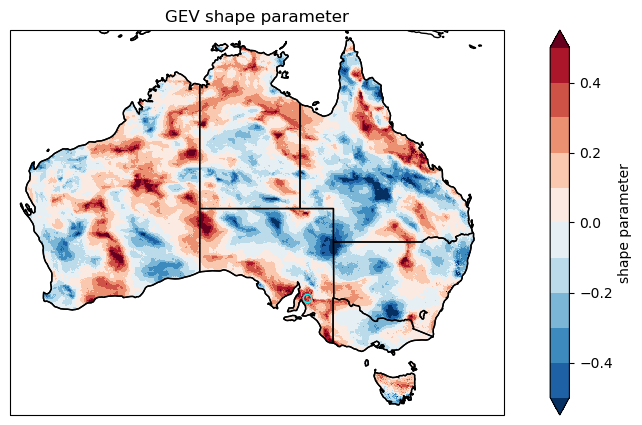

Point shape parameter: 0.28


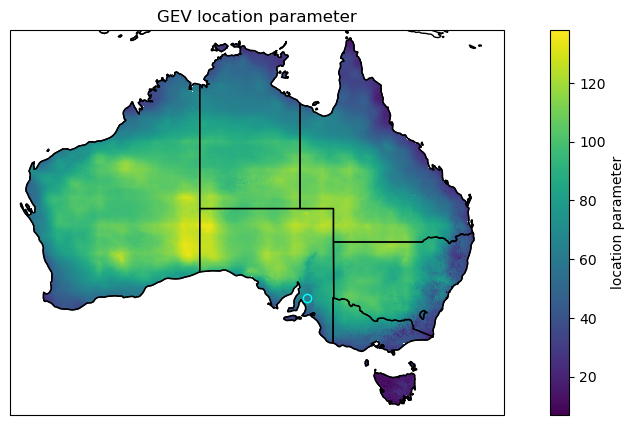

Point location parameter: 59.23


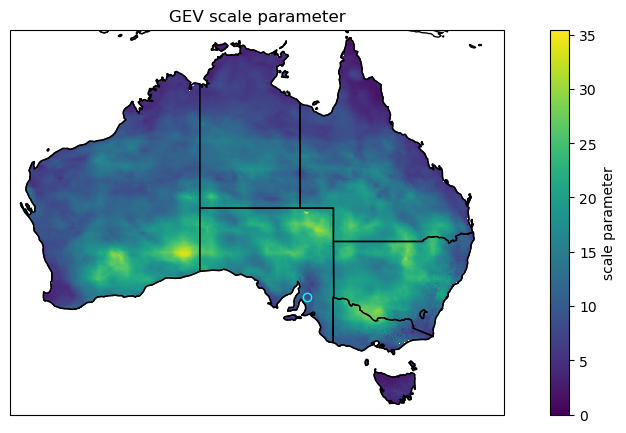

Point scale parameter: 7.93


In [9]:
if os.path.isfile(param_file):
    ds_ari_params = xr.open_dataset(param_file)
    
    da_shape = ds_ari_params[ari_var].sel({'dparams': 'c'})
    plot_aus(
        da_shape,
        'GEV shape parameter',
        outfile=shape_plot,
        levels=np.arange(-0.5, 0.51, 0.1),
        extend='both',
        clabel='shape parameter',
        point=[lon, lat],
    )
    point_shape = da_shape.sel({'lat': lat, 'lon': lon}, method='nearest', drop=True).values
    print(f'Point shape parameter: {point_shape:.2f}')
    
    da_location = ds_ari_params[ari_var].sel({'dparams': 'loc'})
    plot_aus(
        da_location,
        'GEV location parameter',
        outfile=location_plot,
        clabel='location parameter',
        point=[lon, lat],
    )
    point_location = da_location.sel({'lat': lat, 'lon': lon}, method='nearest', drop=True).values
    print(f'Point location parameter: {point_location:.2f}')
    
    da_scale = ds_ari_params[ari_var].sel({'dparams': 'scale'})
    plot_aus(
        da_scale,
        'GEV scale parameter',
        outfile=scale_plot,
        clabel='scale parameter',
        point=[lon, lat],
    )
    point_scale = da_scale.sel({'lat': lat, 'lon': lon}, method='nearest', drop=True).values
    print(f'Point scale parameter: {point_scale:.2f}')

## Point analysis

In [10]:
def plot_diagnostics(point):
    """Plot return period diagnostics for a given grid point"""
    
    lon, lat = point
    data_point = ds_data[data_var].sel({'lat': lat, 'lon': lon}, method='nearest', drop=True)
    str_times = [time.strftime('%Y-%m-%d') for time in data_point['time'].values]
    data_series = pd.Series(data=data_point.values, index=pd.to_datetime(str_times))
    model = EVA(data_series)
    model.get_extremes(method='BM', block_size='365.2425D')
#    print('# The most extreme days')
#    print(model.extremes)
    full_timeseries_fig, ax = model.plot_extremes()
    model.fit_model(distribution='genextreme')    
    summary = model.get_summary(
        return_period=[5, 10, 20, 50],
        alpha=0.95,
        n_samples=1000
    )
    print(summary)

    if os.path.isfile(ari_file):
        ari_point = ds_ari[ari_var].sel({'lat': lat, 'lon': lon}, method='nearest')
        return_period = ari_point.values[0]
        print(f'Return period: {return_period:.2f}')

    if os.path.isfile(param_file):
        params_point = ds_ari_params[ari_var].sel({'lat': lat, 'lon': lon}, method='nearest')
        gev_shape, gev_loc, gev_scale = params_point.values
        print(f'Shape parameter: {gev_shape:.2f}')
        print(f'Location parameter: {gev_loc:.2f}')
        print(f'Scale parameter: {gev_scale:.2f}')

    diagnostic_fig, ax = model.plot_diagnostic(alpha=0.95, return_period=[5, 10, 20, 50])
    

#def plot_pdf(place_name, xrange=[0, 120]):
#    """Plot the PDF and GEV for a given grid point."""    

#    lat, lon = place_latlons[place_name]
#    ffdi_point = ds_ffdi['FFDI'].sel({'lat': lat, 'lon': lon}, method='nearest')
#    ffdi_point_sub = select_resample_op(
#        ffdi_point,
#        op='max',
#        freq='Y',
#    )
#    ari_point = ds_ffdi_ari['FFDI'].sel({'lat': lat, 'lon': lon}, method='nearest')
#    params_point = ds_ffdi_ari_params['FFDI'].sel({'lat': lat, 'lon': lon}, method='nearest')
#    gev_shape, gev_loc, gev_scale = params_point.values

#    fig, ax = plt.subplots(figsize=[6, 4])
#    gev_xvals = np.arange(xrange[0], xrange[1])
#    ffdi_point_sub.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
#    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
#    print(f'Shape parameter: {gev_shape:.2f}')
#    print(f'Location parameter: {gev_loc:.2f}')
#    print(f'Scale parameter: {gev_scale:.2f}')
#    return_period = ari_point.values[0]
#    print(f'Return period: {return_period:.2f}')
#    plt.axvline(return_period, color='0.5', linestyle=':')
#    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
#    plt.xlabel('FFDI')
#    plt.ylabel('probability')
#    plt.title(f'latitude: {lat}; longitude: {lon}')
#    plt.show()
#    plt.close()

               return value   lower ci   upper ci
return period                                    
5.0               68.952737  65.591486  78.553708
10.0              72.487790  68.821796  78.567967
20.0              75.250616  70.785442  79.113681
50.0              78.095400  72.223019  85.632993
Return period: 75.25
Shape parameter: 0.28
Location parameter: 59.23
Scale parameter: 7.93


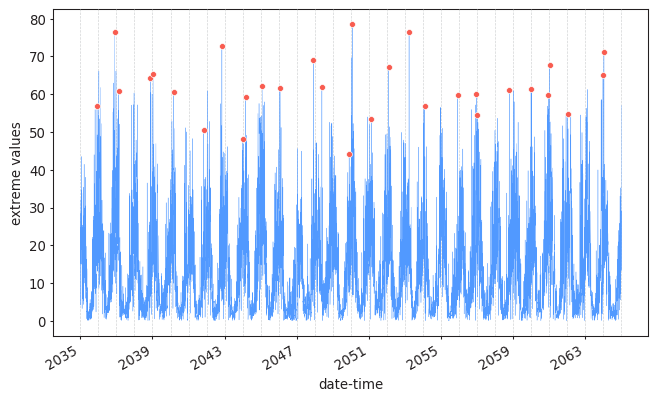

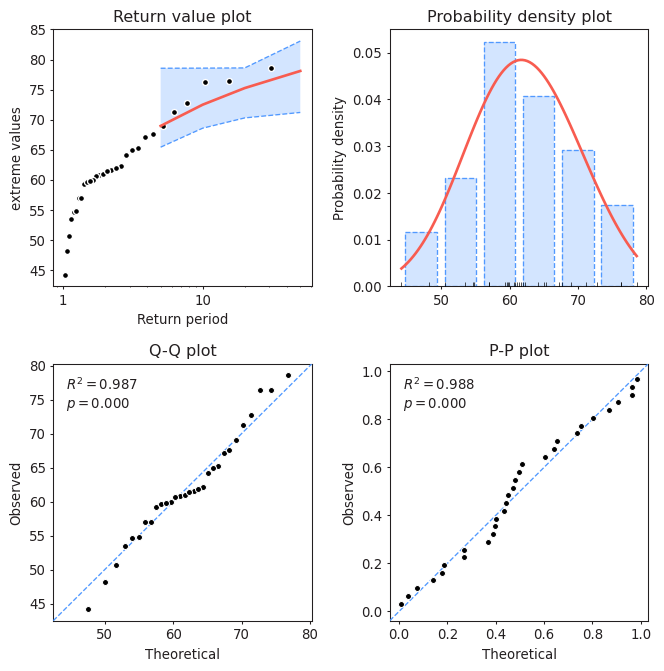

In [11]:
if data_files:
    plot_diagnostics([lon, lat])